In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rc('axes', titlesize=14)
plt.rc('font', size=14)


### Model and Functions

In [17]:
def poisson_spike_train(mean_rate,effective, t_sim, dt): 
    """
    mean_rate: float, mean firing rate in Hz
    effective: array, probability of firing for each time step derived from released neurotransmitters
    t_sim: float, simulation time in seconds
    dt: float, time step in seconds

    Returns:
    spike_inh: array, binary array of post synaptic spikes in case of inhibitory synapse
    spike_exc: array, binary array of post synaptic spikes in case of excitatory synapse
    """
    spike_inh= np.zeros(int(t_sim/dt))
    spike_exc= np.zeros(int(t_sim/dt))
    
    rate_inh =  1- effective
    rate_inh = mean_rate*rate_inh

    rate_exc = effective
    rate_exc = mean_rate*rate_exc

    for t in range(int(t_sim/dt)):
        ran_num = np.random.rand()
        survival_inh = 1 - np.exp(-rate_inh[t]*dt)
        spike_inh[t] = np.random.rand() < survival_inh

        survival_exc = 1 - np.exp(-rate_exc[t]*dt)
        spike_exc[t] = np.random.rand() < survival_exc
    return spike_inh, spike_exc


def two_close_spikes(t_sim, dt, third_spike=False, interval=20):
    spike = np.zeros(int(t_sim/dt))
    spike[100] = 1
    spike[120] = 1
    if third_spike:
        spike[120+interval] = 1
    return spike

def regular_spikes(t_sim, dt, rate):
    spike = np.zeros(int(t_sim/dt))
    for i in range(0, len(spike), int(1/(rate*dt))):
        spike[i] = 1
    return spike

def calcium_concentration(spike, tau_c, t_sim, dt, R1):
    spike = spike * R1 #R is the amount of calcium ions released per spike
    calcium = np.zeros(int(t_sim/dt))
    for i in range(1, len(spike)):
        calcium[i] = calcium[i-1]*(1-dt/tau_c) + dt/tau_c* spike[i-1]
    return calcium

def vesicle_fusion( tau_v, t_sim, dt, v_0, release_delay,R2, alpha, calcium, spike):
    release = np.zeros(int(t_sim/dt))
    release_delay = int(release_delay/dt)
    
    vecicle = np.zeros(int(t_sim/dt))
    vecicle[0]=v_0
    for i in range(1, len(release)):
        vecicle[i] =  (1 - dt/tau_v) * vecicle[i-1] + dt/tau_v * (v_0 - R2*release[i-1]) 
        release[i] = alpha*calcium[i-release_delay]* spike[i-release_delay]* (vecicle[i-release_delay])
    return vecicle, release

def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    
    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid 
        lmax = lmax[s[lmax]>s_mid]

    # global min of dmin-chunks of locals min 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global max of dmax-chunks of locals max 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax


### response to two close spikes

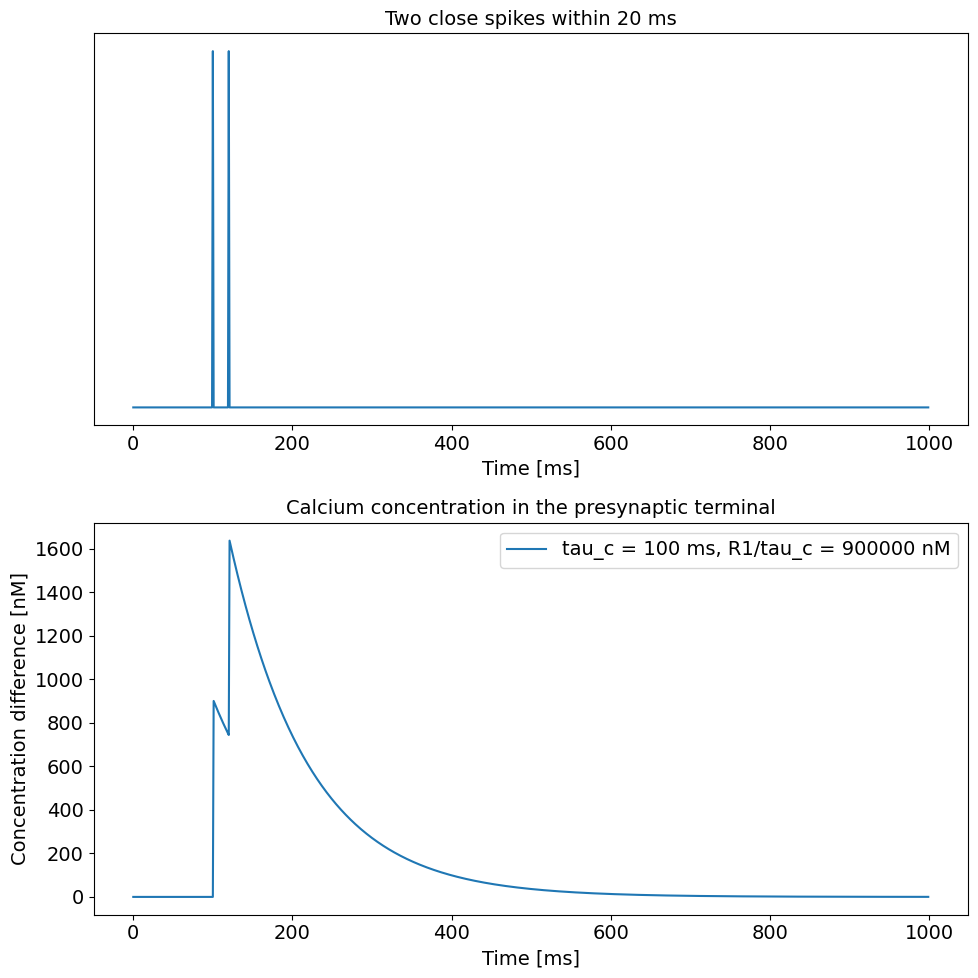

In [3]:
t_sim= 1
dt = 0.001

tau_c = 100*dt 
R1 = 9e5* tau_c

spike = two_close_spikes(t_sim, dt)
# spike = np.heaviside(np.arange(0, t_sim, dt) - 0.1, 1)

calcium = calcium_concentration(spike, tau_c, t_sim, dt, R1)

fig, ax = plt.subplots(2,1, figsize=(10,10), layout='tight')
ax[0].plot(spike)
ax[0].set_title('Two close spikes within 20 ms')
ax[0].set_xlabel('Time [ms]')
ax[0].set_yticks([])
# ax[0].set_ylabel('Spike')


ax[1].plot(calcium, label=f'tau_c = {int(tau_c/dt)} ms, R1/tau_c = {int(R1/tau_c)} nM')
ax[1].set_title('Calcium concentration in the presynaptic terminal')
ax[1].set_ylabel('Concentration difference [nM]')
ax[1].set_xlabel('Time [ms]')
ax[1].legend()


127.5834567752809


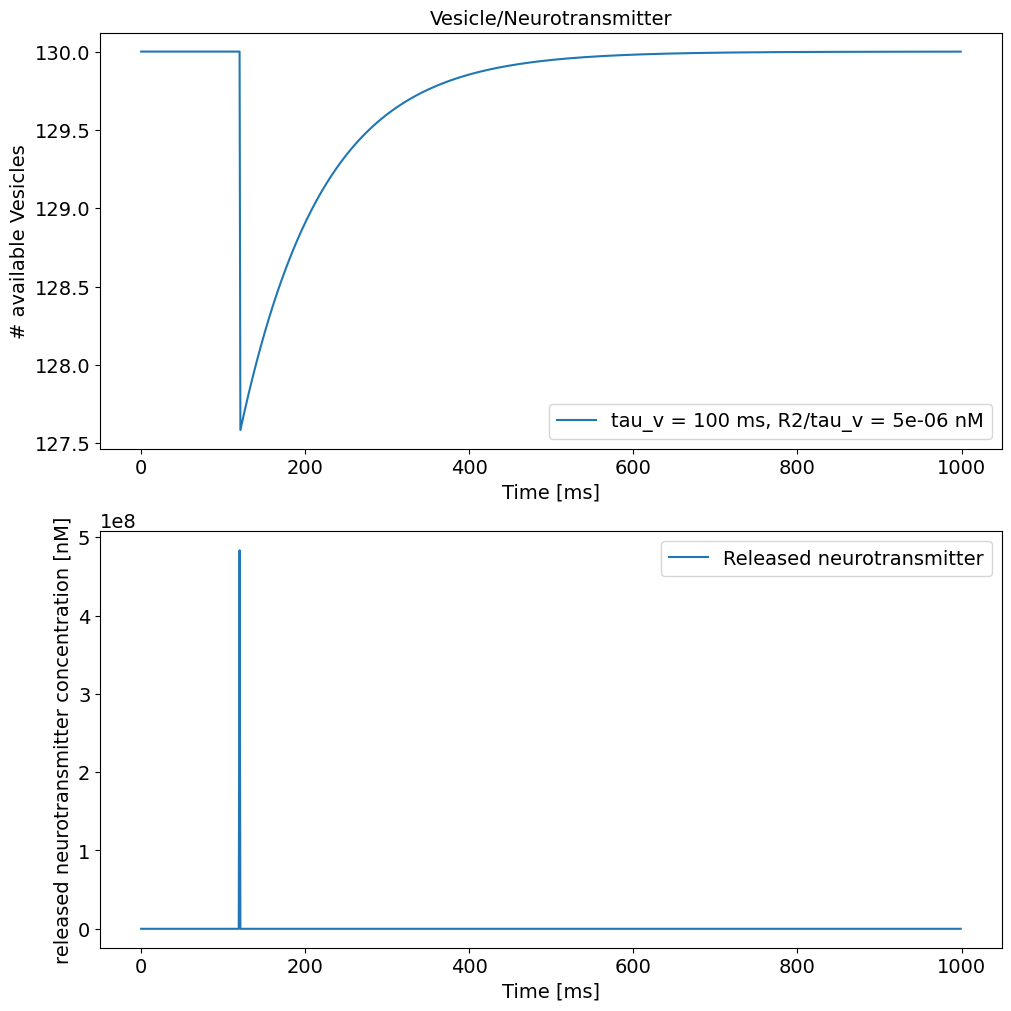

In [4]:
tau_v = 100*dt 

R2=5e-6* tau_v #rate of vesicle release
v_0 = 130 #maximum vesicle pool size
release_delay = 0 #delay between calcium influx and vesicle release
alpha=5e3

vesicle, release = vesicle_fusion(tau_v, t_sim, dt, v_0, release_delay, R2,alpha, calcium, spike)
# convert nM to MM
# release = release/1e6

print(vesicle[121])

fig, ax = plt.subplots(2,1, figsize=(10,10), layout='constrained')

ax[0].plot(vesicle, label=f'tau_v = {int(tau_v/dt)} ms, R2/tau_v = {(R2/tau_v)} nM')
# ax[0].plot(release, label='Released neurotransmitter')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('# available Vesicles')
ax[0].set_title('Vesicle/Neurotransmitter')
ax[0].legend()
# ax[0].plot(vesicle, label='available Vesicles')
ax[1].plot(release, label='Released neurotransmitter')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('released neurotransmitter concentration [nM]')
# ax[1].set_title('Vesicle Pool')
ax[1].legend()
plt.show()


### Facilitaion

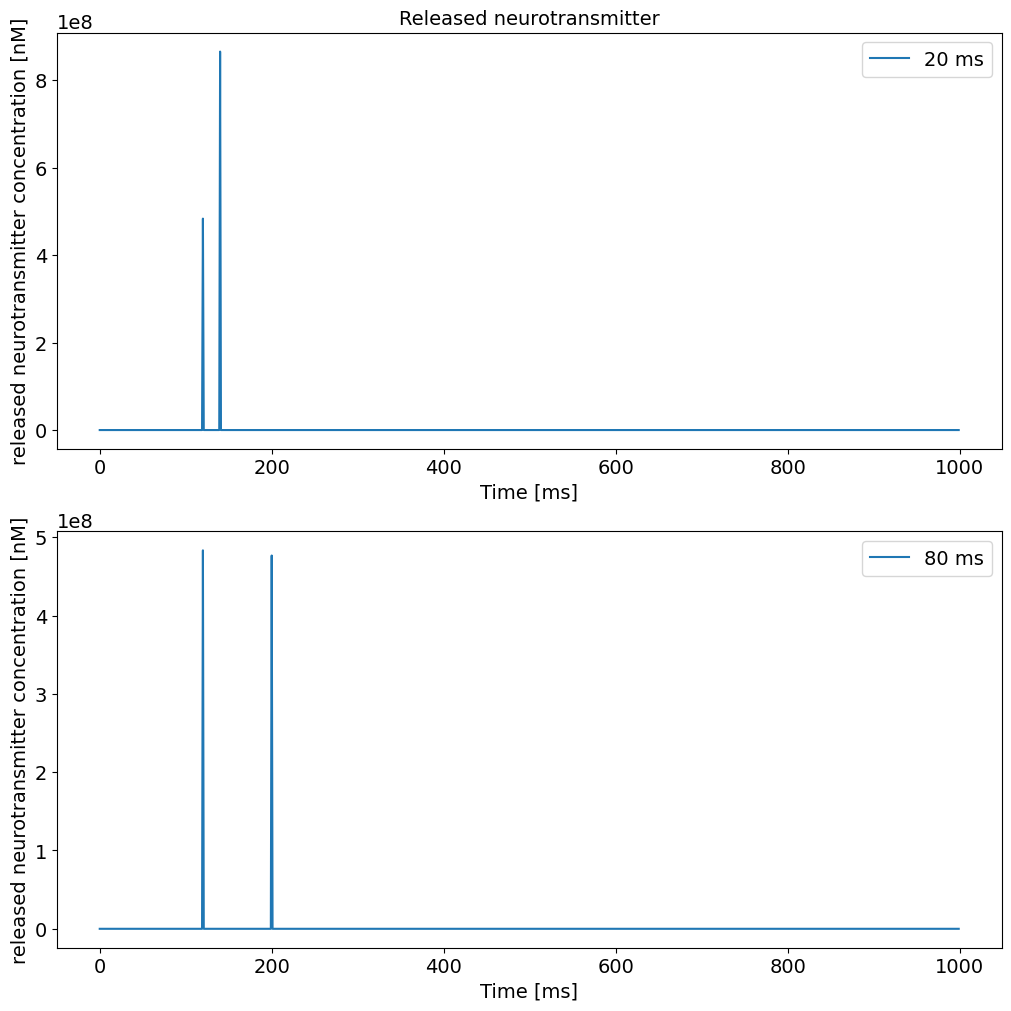

In [5]:
spike = two_close_spikes(t_sim, dt, third_spike=True)
calcium = calcium_concentration(spike, tau_c, t_sim, dt, R1)
vesicle, release1 = vesicle_fusion(tau_v, t_sim, dt, v_0, release_delay, R2,alpha, calcium, spike)

spike = two_close_spikes(t_sim, dt, third_spike=True, interval=80)
calcium = calcium_concentration(spike, tau_c, t_sim, dt, R1)
vesicle, release2 = vesicle_fusion(tau_v, t_sim, dt, v_0, release_delay, R2,alpha, calcium, spike)

fig, ax = plt.subplots(2,1, figsize=(10,10), layout='constrained')
ax[0].plot(release1, label='20 ms')
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('released neurotransmitter concentration [nM]')
ax[0].set_title('Released neurotransmitter')
ax[0].legend()

ax[1].plot(release2, label='80 ms')
ax[1].set_xlabel('Time [ms]')
ax[1].set_ylabel('released neurotransmitter concentration [nM]')
ax[1].legend()

plt.show()

### Time Constants and Adaptation

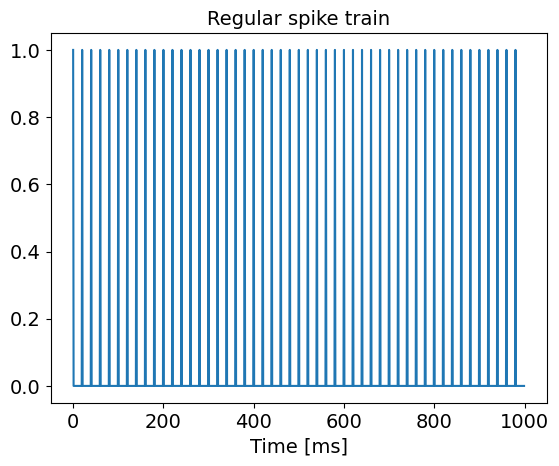

Text(0.5, 0.98, 'Released neurotransmitter ')

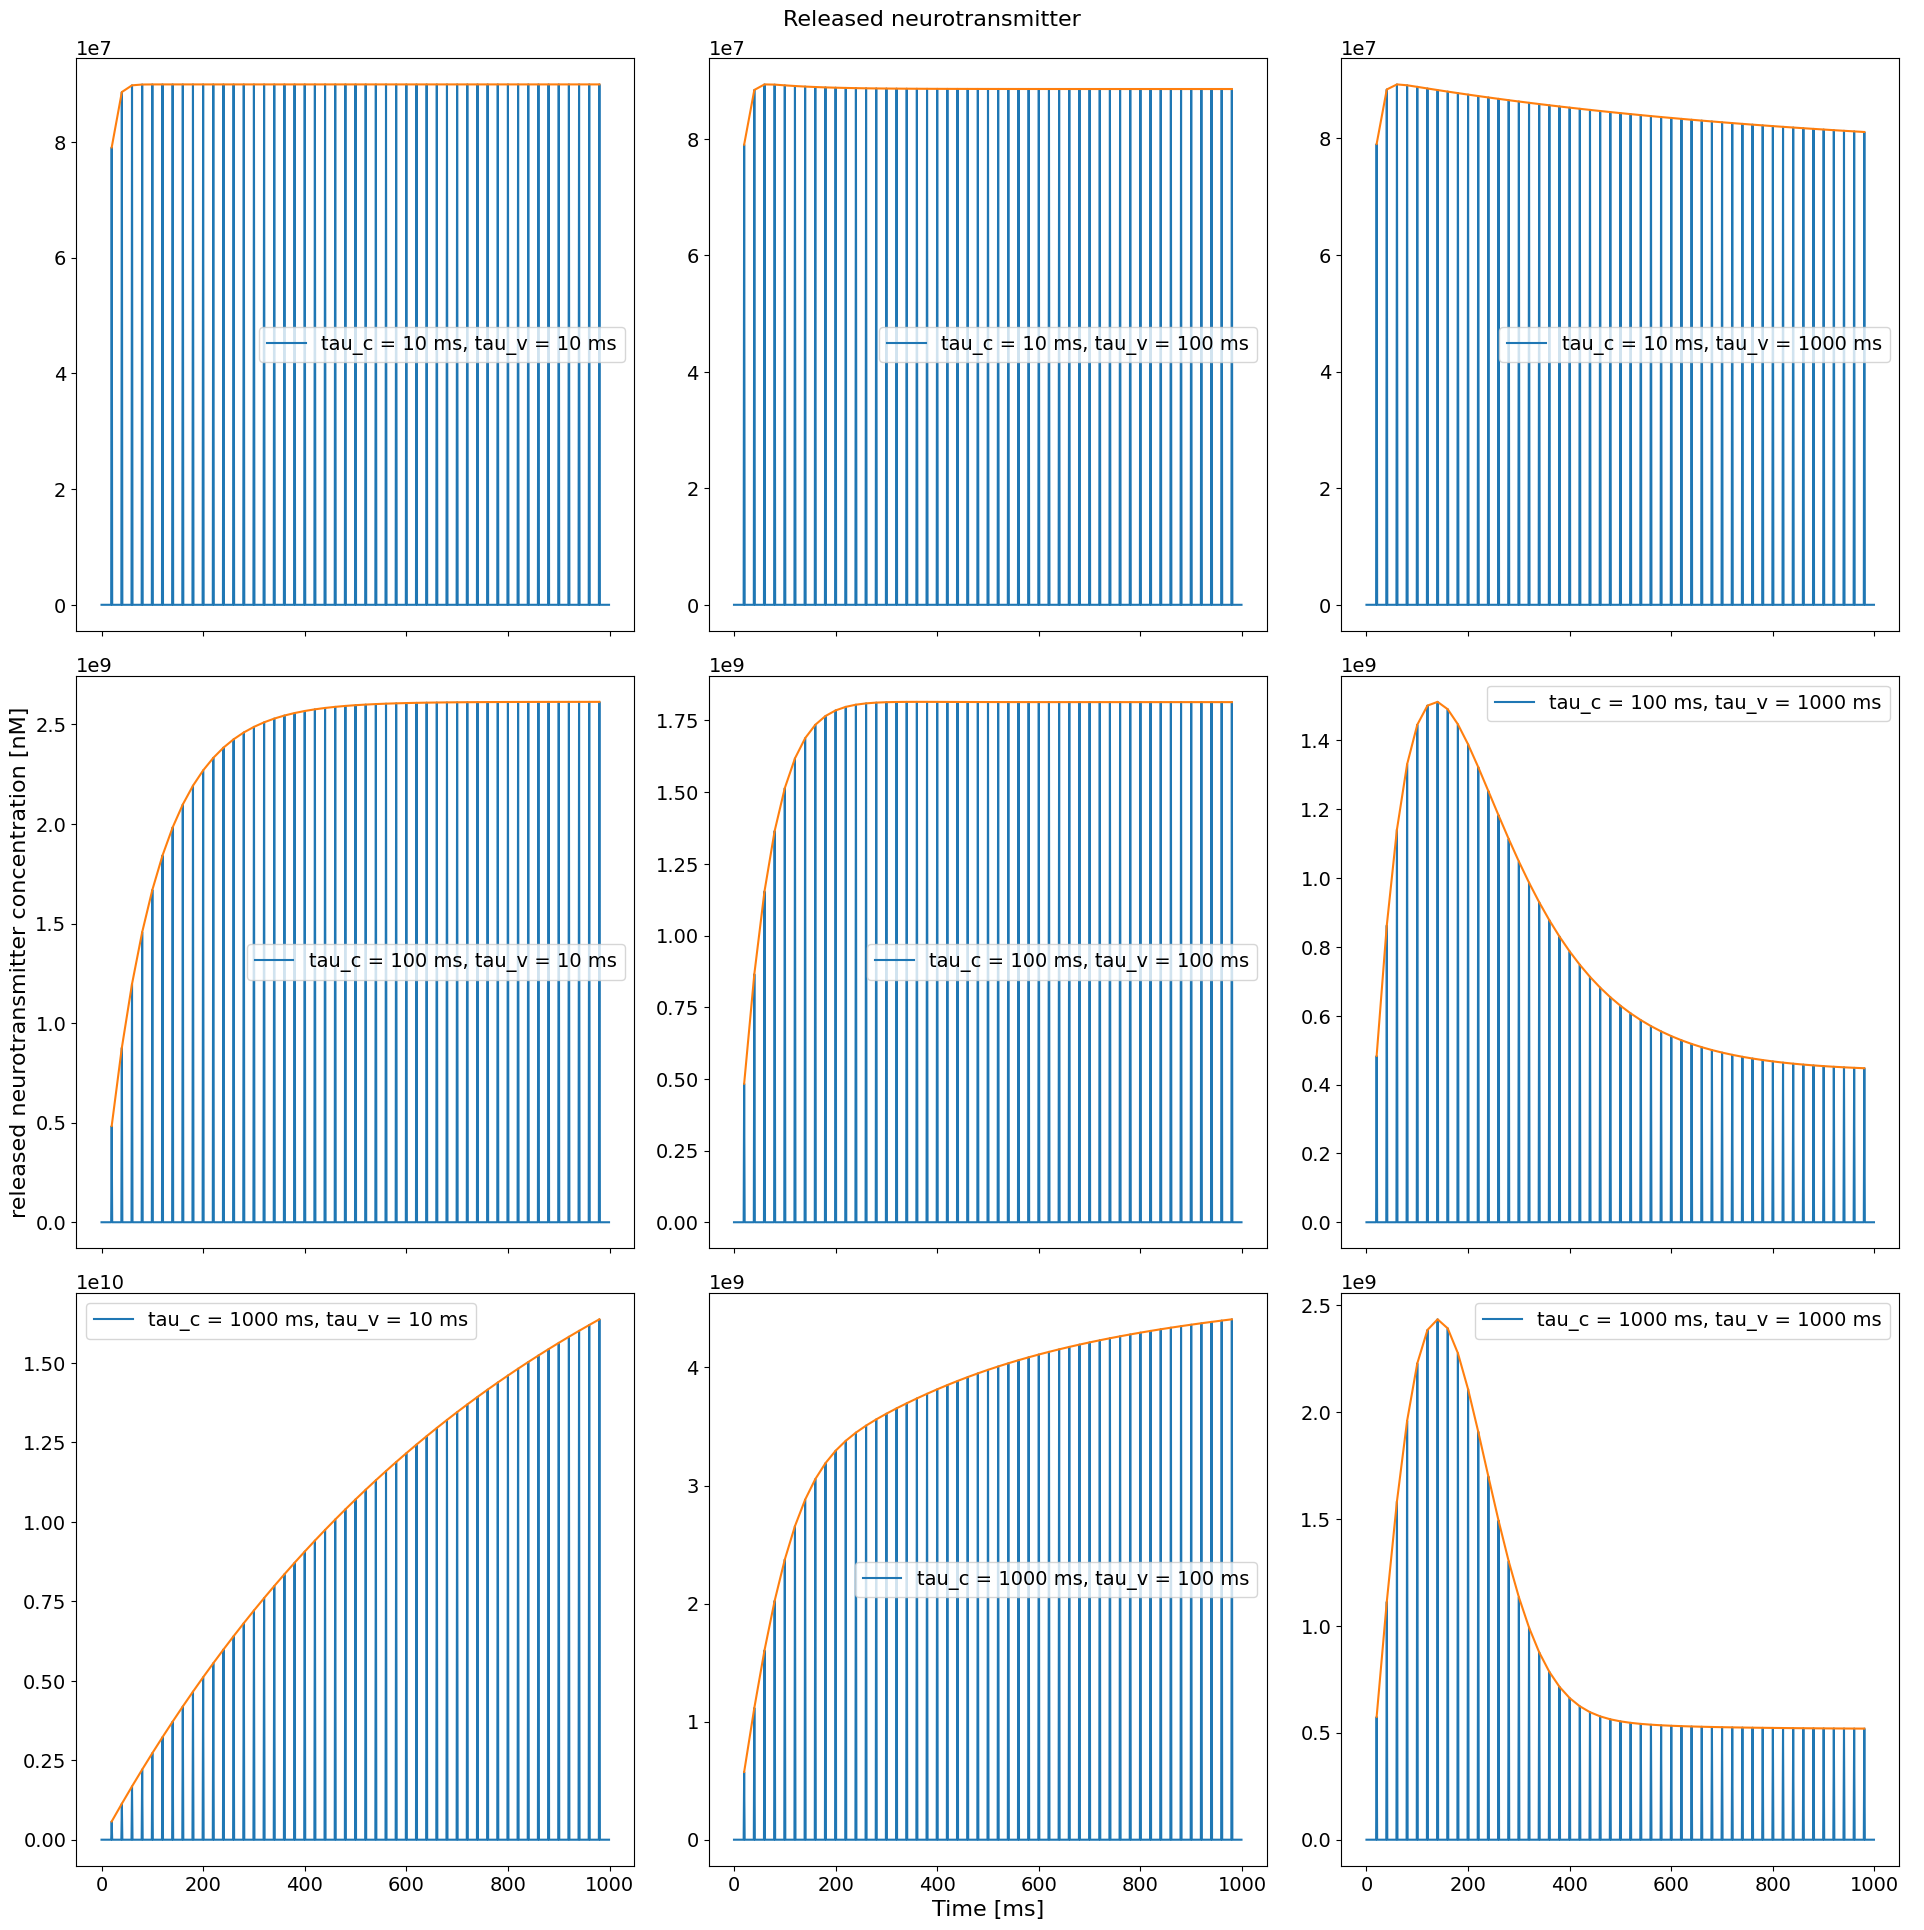

In [6]:
t_sim= 1
dt = 0.001
v_0 = 130

spike = regular_spikes(t_sim, dt, 50)

plt.plot(spike)
plt.title('Regular spike train')
plt.xlabel('Time [ms]')
plt.show()
alpha=5e3
release_delay = 0

taus  = [10, 100, 1000]
fig, ax = plt.subplots(len(taus), len(taus), figsize=(20,20), layout="tight", sharex=True, sharey=False)
for i in range(len(taus)):
    for j in range(len(taus)):
        tau_c = taus[i] *dt 
        R1 = 9e5 * tau_c

        tau_v = taus[j] *dt
        R2=5e-6* tau_v #rate of vesicle release

        calcium = calcium_concentration(spike, tau_c, t_sim, dt, R1)
        vesicle, release = vesicle_fusion(tau_v, t_sim, dt, v_0, release_delay, R2,alpha, calcium, spike)
        
        ax[i,j].plot(release, label=f'tau_c = {int(tau_c/dt)} ms, tau_v = {int(tau_v/dt)} ms')
        
        rmin, rmax = hl_envelopes_idx(release)
        
        ax[i,j].plot(rmax, release[rmax])
        ax[i,j].legend()
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time [ms]", size=16)
plt.ylabel("released neurotransmitter concentration [nM]", size = 16)
plt.savefig('vesicle_release.png')
fig.suptitle('Released neurotransmitter ', fontsize=16)
  

### signal envelope and normalized effective release

Text(0, 0.5, 'normalized valus')

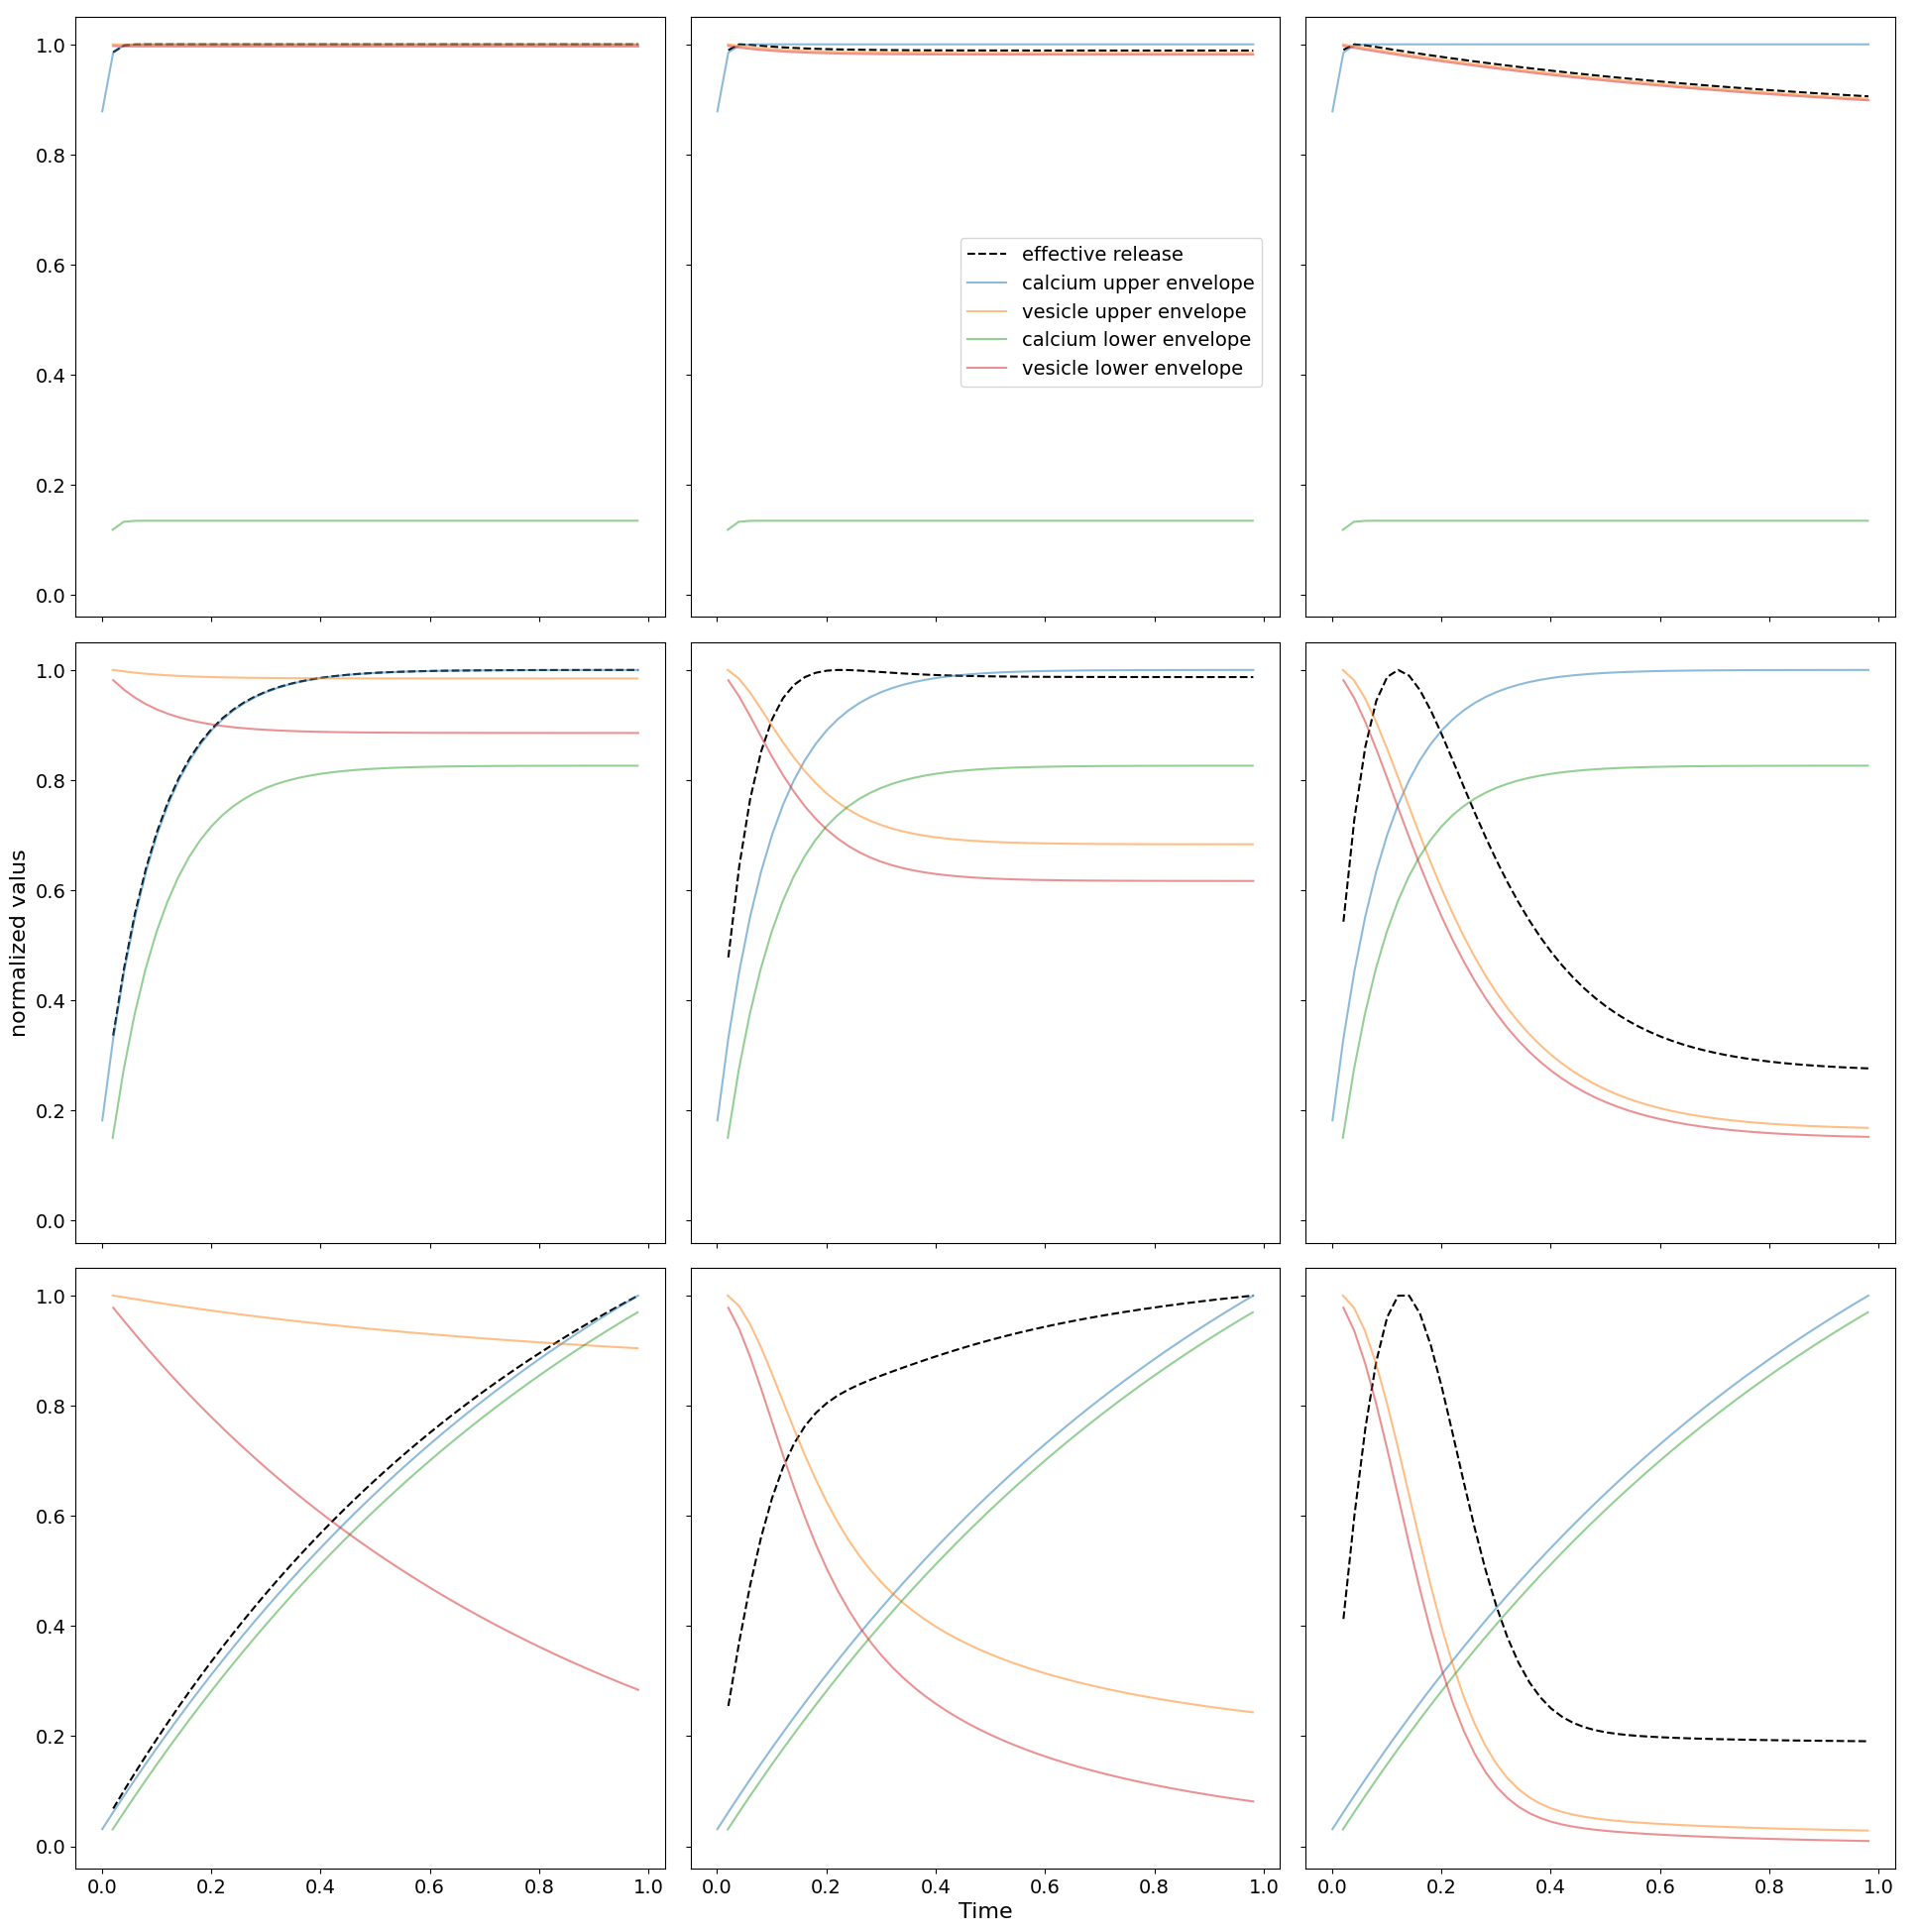

In [7]:
taus  = [10, 100, 1000]
t= np.arange(0, t_sim, dt)
fig, ax = plt.subplots(len(taus), len(taus), figsize=(20,20), layout="tight", sharex=True, sharey=True)
for i in range(len(taus)):
    for j in range(len(taus)):
        tau_c = taus[i] *dt 
        R1 = 9e5 * tau_c

        tau_v = taus[j] *dt
        R2=5e-6* tau_v #rate of vesicle release

        calcium = calcium_concentration(spike, tau_c, t_sim, dt, R1)
        vesicle, release = vesicle_fusion(tau_v, t_sim, dt, v_0, release_delay, R2,alpha, calcium, spike)
        

        vesicle = vesicle/np.max(vesicle)
        calcium = calcium/np.max(calcium)

        cmin,cmax = hl_envelopes_idx(calcium)
        vmin, vmax = hl_envelopes_idx(vesicle)

        effective = calcium[cmax[1:]] * vesicle[vmax]
        effective = effective/np.max(effective)
        ax[i,j].plot(t[cmax[1:]],effective, label=f'effective release', color='black', linestyle='--')
        
        ax[i,j].plot(t[cmax],calcium[cmax], label=f'calcium upper envelope', alpha=0.5)
        ax[i,j].plot(t[vmax],vesicle[vmax], label=f'vesicle upper envelope' ,alpha=0.5)

        ax[i,j].plot(t[cmin],calcium[cmin], label='calcium lower envelope', alpha=0.5)
        ax[i,j].plot(t[vmin],vesicle[vmin], label='vesicle lower envelope', alpha=0.5)

handels, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handels, labels, loc=(0.5, 0.8))
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time", size=16)
plt.ylabel("normalized valus", size = 16)        

### Poisson spike train with rate modulation

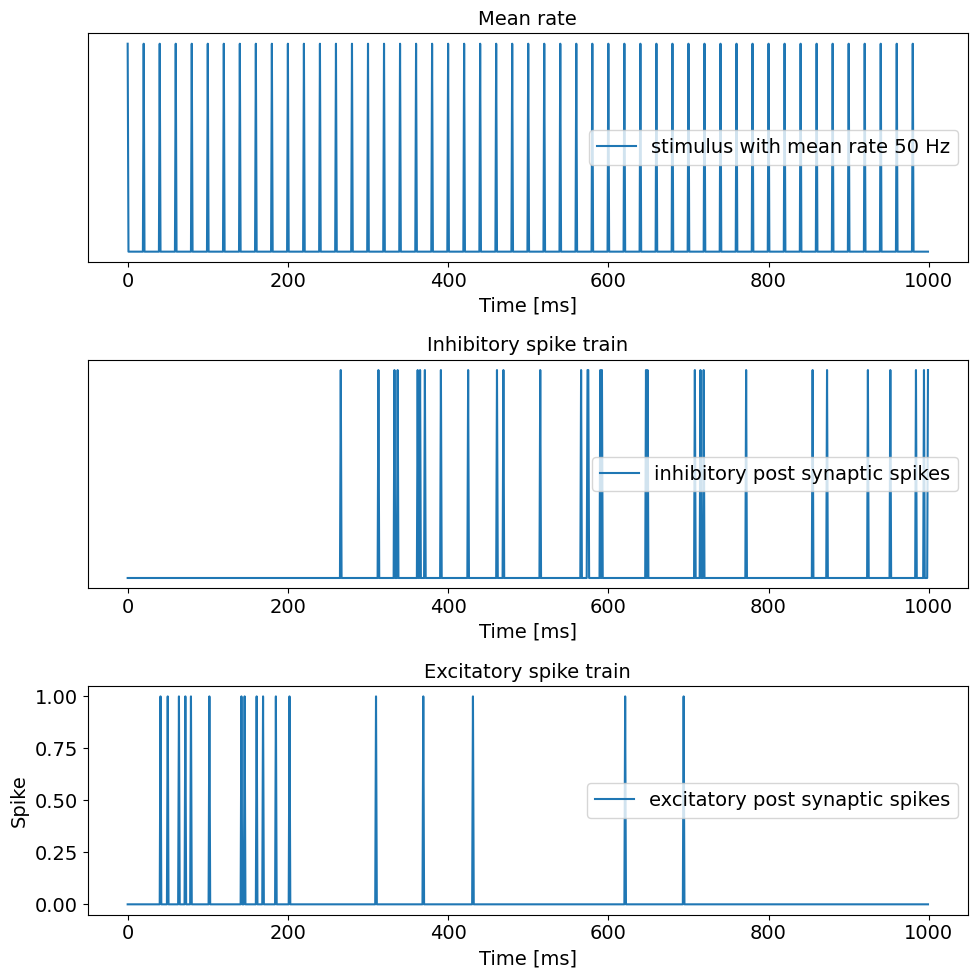

In [24]:
#extend through time
scaled_effective =np.zeros(int(t_sim/dt))
ratio = len(scaled_effective)/len(effective)
ratio = int(ratio) 

for t in range(len(effective)):
    scaled_effective[t*ratio:(t+1)*ratio] = effective[t]
# mean rate
mean_rate = 50
spike_inh, spike_exc = poisson_spike_train(mean_rate, scaled_effective, t_sim, dt)
fig, ax = plt.subplots(3,1, figsize=(10,10), layout='tight')

ax[0].plot(regular_spikes(t_sim, dt, mean_rate), label='stimulus with mean rate 50 Hz')
ax[0].set_title('Mean rate')
ax[0].set_xlabel('Time [ms]')
ax[0].set_yticks([])
ax[0].legend()

ax[1].plot(spike_inh, label='inhibitory post synaptic spikes')
ax[1].set_title('Inhibitory spike train')
ax[1].set_xlabel('Time [ms]')
ax[1].set_yticks([])
ax[1].legend()

ax[2].plot(spike_exc, label='excitatory post synaptic spikes')
ax[2].set_title('Excitatory spike train')
ax[2].set_ylabel('Spike')
ax[2].set_xlabel('Time [ms]')
ax[2].legend()
